In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

In [2]:
from core.utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")

x, y = df_to_xy(df, fuse_risk=True)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)

      prop  other_resp  other_prop   selfish  time_spent_prop  count_effort  \
0     50.0        50.0        50.0  1.000000         0.115242          20.0   
1     50.0        20.0        20.0  0.333333         0.141264          20.0   
2    120.0        50.0        80.0  0.333333         0.256506          12.0   
3     50.0        50.0        50.0  1.000000         0.096654          14.0   
4    100.0        50.0        50.0  1.000000         0.159851           4.0   
5    100.0       100.0        50.0  0.333333         0.208178          11.0   
6    100.0       100.0       100.0  0.666667         0.130112          14.0   
7    120.0       100.0       120.0  0.500000         0.137546          15.0   
8     90.0        80.0        70.0  0.000000         0.308550          15.0   
9     60.0        50.0        45.0  0.416667         0.104089          17.0   
10   100.0       100.0       100.0  0.666667         0.156134          12.0   
11   125.0       110.0       115.0  0.333333        

**Loss function**

In [3]:
@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss(x):
    offset = 1
    x1 = (x + offset) / 16.0
    x2 = (x) / 40.0
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain(x):
    return 1 - loss(x)

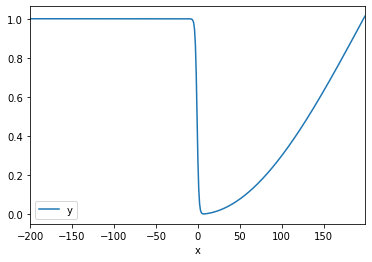

In [4]:
x = np.arange(-200, 200, 1)
y = loss(x)

out_df = pd.DataFrame({'x':x, 'y':y})
out_df.plot.line(x='x', y='y')

In [5]:
from core.utils.data_augmentation import DACombine

In [6]:
from core.models.deep import keras_hiddenless_model, keras_model, loss_tf, gain_tf, KerasModel
from keras import backend as K

Using TensorFlow backend.


**Metrics**

In [7]:
from core.models.metrics import gain_mean, avg_gain_ratio

**Model: No data Augmentation**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


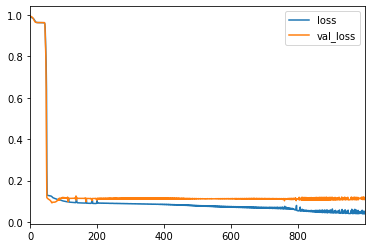

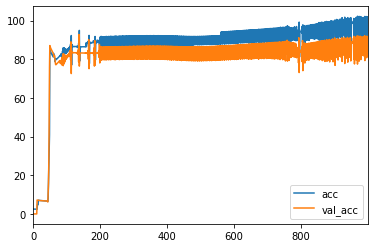

In [8]:
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=256, epochs=1000)
da = DACombine()
xTrain_a, yTrain_a = xTrain.astype(K.floatx()), yTrain.astype(K.floatx())
split = int(xTrain.shape[1] * 0.75)
#xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype(K.floatx()), yTrain_a.astype(K.floatx()),  validation_split=0.25, verbose=0)

#print(history.history)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  82.35550536049738
gain_ratio:  0.6575754757555909


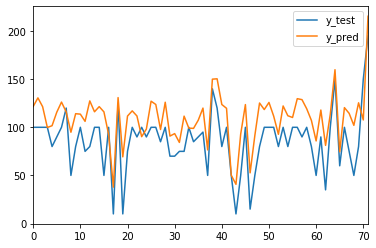

In [9]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

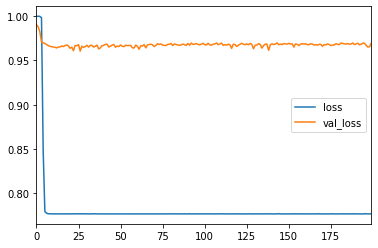

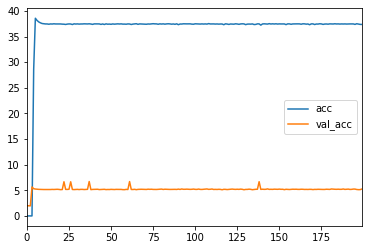

In [10]:
#sci-kit like training
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=30, epochs=200)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  2.625
gain_ratio:  0.01381578947368421


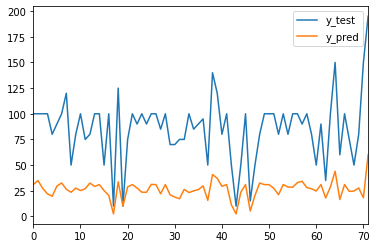

In [11]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

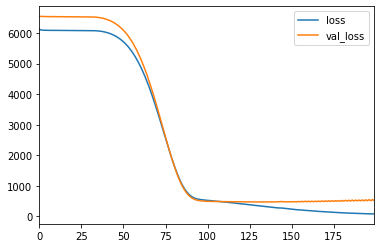

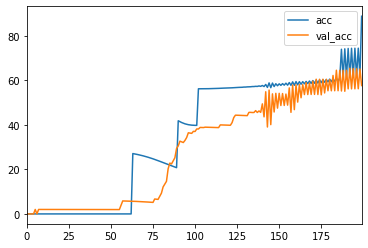

In [12]:
#sci-kit like training
model = KerasModel(loss='mse', metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal))
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  35.34722222222222
gain_ratio:  0.26464763836803307


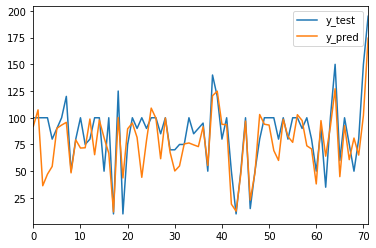

In [13]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**CMP Model**

Train on 85 samples, validate on 22 samples
Epoch 1/200
85/85 [==============================] - 0s 6ms/step - loss: 0.9878 - gain_tf: 2.3465 - val_loss: 0.9998 - val_gain_tf: 0.0000e+00
Epoch 2/200
85/85 [==============================] - 0s 134us/step - loss: 0.9521 - gain_tf: 8.1753 - val_loss: 0.9625 - val_gain_tf: 6.7622
Epoch 3/200
85/85 [==============================] - 0s 160us/step - loss: 0.9112 - gain_tf: 10.9700 - val_loss: 0.6666 - val_gain_tf: 41.8252
Epoch 4/200
85/85 [==============================] - 0s 165us/step - loss: 0.6596 - gain_tf: 37.8963 - val_loss: 0.0870 - val_gain_tf: 81.7994
Epoch 5/200
85/85 [==============================] - 0s 163us/step - loss: 0.1352 - gain_tf: 79.5025 - val_loss: 0.0891 - val_gain_tf: 78.6980
Epoch 6/200
85/85 [==============================] - 0s 500us/step - loss: 0.1268 - gain_tf: 79.4877 - val_loss: 0.0965 - val_gain_tf: 74.7706
Epoch 7/200
85/85 [==============================] - 0s 144us/step - loss: 0.1218 - gain_tf: 76.7812

Epoch 58/200
85/85 [==============================] - 0s 128us/step - loss: 0.1090 - gain_tf: 76.8804 - val_loss: 0.1242 - val_gain_tf: 74.7229
Epoch 59/200
85/85 [==============================] - 0s 125us/step - loss: 0.0934 - gain_tf: 82.0032 - val_loss: 0.1261 - val_gain_tf: 78.8722
Epoch 60/200
85/85 [==============================] - 0s 154us/step - loss: 0.0887 - gain_tf: 86.2877 - val_loss: 0.1253 - val_gain_tf: 79.5224
Epoch 61/200
85/85 [==============================] - 0s 142us/step - loss: 0.0872 - gain_tf: 86.9848 - val_loss: 0.1248 - val_gain_tf: 79.8403
Epoch 62/200
85/85 [==============================] - 0s 160us/step - loss: 0.0860 - gain_tf: 87.3418 - val_loss: 0.1255 - val_gain_tf: 79.4900
Epoch 63/200
85/85 [==============================] - 0s 143us/step - loss: 0.0846 - gain_tf: 87.0002 - val_loss: 0.1267 - val_gain_tf: 78.7482
Epoch 64/200
85/85 [==============================] - 0s 148us/step - loss: 0.0826 - gain_tf: 86.2211 - val_loss: 0.1265 - val_gain_tf: 

Epoch 115/200
85/85 [==============================] - 0s 170us/step - loss: 0.0768 - gain_tf: 86.1508 - val_loss: 0.1308 - val_gain_tf: 83.2278
Epoch 116/200
85/85 [==============================] - 0s 170us/step - loss: 0.0677 - gain_tf: 95.5113 - val_loss: 0.1377 - val_gain_tf: 73.8412
Epoch 117/200
85/85 [==============================] - 0s 168us/step - loss: 0.0813 - gain_tf: 84.1634 - val_loss: 0.1282 - val_gain_tf: 87.0831
Epoch 118/200
85/85 [==============================] - 0s 186us/step - loss: 0.0655 - gain_tf: 94.7880 - val_loss: 0.1307 - val_gain_tf: 76.9649
Epoch 119/200
85/85 [==============================] - 0s 150us/step - loss: 0.0737 - gain_tf: 87.4288 - val_loss: 0.1373 - val_gain_tf: 84.2327
Epoch 120/200
85/85 [==============================] - 0s 205us/step - loss: 0.0703 - gain_tf: 96.5900 - val_loss: 0.1522 - val_gain_tf: 68.1085
Epoch 121/200
85/85 [==============================] - 0s 196us/step - loss: 0.0973 - gain_tf: 78.1073 - val_loss: 0.1214 - val_ga

Epoch 172/200
85/85 [==============================] - 0s 173us/step - loss: 0.0789 - gain_tf: 84.4516 - val_loss: 0.1342 - val_gain_tf: 82.0628
Epoch 173/200
85/85 [==============================] - 0s 193us/step - loss: 0.0567 - gain_tf: 97.0700 - val_loss: 0.1387 - val_gain_tf: 82.8510
Epoch 174/200
85/85 [==============================] - 0s 168us/step - loss: 0.0564 - gain_tf: 97.9220 - val_loss: 0.1314 - val_gain_tf: 85.5316
Epoch 175/200
85/85 [==============================] - 0s 182us/step - loss: 0.0569 - gain_tf: 95.8888 - val_loss: 0.1504 - val_gain_tf: 85.3077
Epoch 176/200
85/85 [==============================] - 0s 168us/step - loss: 0.0608 - gain_tf: 100.5716 - val_loss: 0.1436 - val_gain_tf: 71.2554
Epoch 177/200
85/85 [==============================] - 0s 150us/step - loss: 0.0878 - gain_tf: 81.0075 - val_loss: 0.1333 - val_gain_tf: 81.7574
Epoch 178/200
85/85 [==============================] - 0s 199us/step - loss: 0.0564 - gain_tf: 96.6877 - val_loss: 0.1450 - val_g

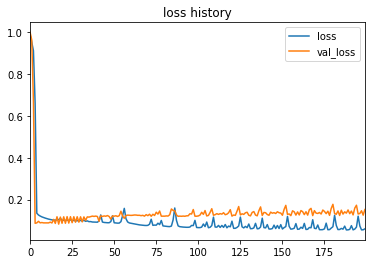

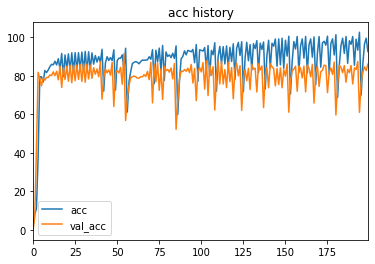

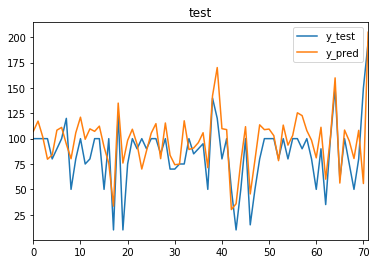

In [14]:
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, ActivityRegularization


drop_rate = 0.015
model = Sequential()
model.add(Dense(10240, activation='relu', input_shape=(xTrain.shape[1],)))
#model.add(Dropout(rate=drop_rate))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1, activation='linear'))
model.compile(loss=loss_tf,
              optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])

history = model.fit(xTrain, yTrain, epochs=200, verbose=1, batch_size=512, validation_split=0.20)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(title="loss history")

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(title="acc history")

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = model.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio: ", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [16]:
# from core.models import AcceptanceModel
# from core.utils.data_augmentation import DASampling


# drop_rate = 0.15
# model = Sequential()
# model.add(Dense(2000, activation='relu', input_shape=(11,)))
# #model.add(Dropout(rate=drop_rate))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# model.add(Dense(275, activation='relu'))
# #model.add(Dropout(rate=drop_rate))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss="mse",
#               optimizer='rmsprop',#optimizer=RMSprop(lr=0.0001),
#               metrics=[gain_tf])
# amodel = AcceptanceModel(model)
# axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 10000)
# amodel.fit(
#     axTrain,
#     ayTrain,
#     fit_kwargs={
#         "epochs": 16,
#         "batch_size": 10240,
#         "validation_split": 0.2,
#         "verbose": 1
#     }
# )
# # amodel.fit(
# #     xTrain,
# #     yTrain,
# #     fit_kwargs={
# #         "epochs": 8,
# #         "batch_size": 10000,
# #         #"validation_split": 0.2,
# #         "verbose":1
# #     }
# # )

# yPred = amodel.predict(xTest, predict_kwargs={"batch_size": 10000})

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
# out_data.plot(title="test")

# yPred = amodel.predict(xTest)
# print("train gain: ", gain_mean(yTrain.ravel(), amodel.predict(xTrain).ravel()))
# print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), amodel.predict(xTrain).ravel()))

# print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
# print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

Train on 328000 samples, validate on 82000 samples
Epoch 1/16
328000/328000 [==============================] - 3s 8us/step - loss: 0.9706 - gain_tf: 74.0321 - val_loss: 0.9523 - val_gain_tf: 73.8782
Epoch 2/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.9379 - gain_tf: 74.0090 - val_loss: 0.9405 - val_gain_tf: 73.9675
Epoch 3/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.9369 - gain_tf: 74.0137 - val_loss: 0.9324 - val_gain_tf: 73.9378
Epoch 4/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.9338 - gain_tf: 74.0167 - val_loss: 0.9325 - val_gain_tf: 73.9297
Epoch 5/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.9338 - gain_tf: 74.0185 - val_loss: 0.9999 - val_gain_tf: 74.0268
Epoch 6/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.9454 - gain_tf: 74.0353 - val_loss: 0.9300 - val_gain_tf: 73.9187
Epoch 7/16
328000/328000 [==============================] - 2

SystemError: PyEval_EvalFrameEx returned a result with an error set

In [17]:
axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 1000)
aamodel = AcceptanceModel.get_trained_model(xTrain=axTrain, yTrain=ayTrain)

yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))


KeyboardInterrupt: 

In [ ]:
aamodel.fit(xTrain, yTrain)
yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [18]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

model = RandomForestClassifier(
    n_estimators=256,
    criterion="entropy",
    #min_samples_split=3,
    #bootstrap_features=True,
    n_jobs=8
)
model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024, ),
    solver='sgd',
    max_iter=512,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
model.fit(xTrain, yTrain.ravel())

yPred = model.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

train gain:  119.57943925233644
train gain_ratio 0.9616147617112671
gain_mean:  59.513888888888886
gain_ratio:  0.484415110971175


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': ['auto', 512],
    'learning_rate_init': [0.001, 0.0001, 0.00001]
}

model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=128,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
clf = GridSearchCV(model, parameters, cv=3,)

clf.fit(xTrain, yTrain.ravel())

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/franck/

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:351: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:351: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size

In [ ]:

yPred = clf.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), clf.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), clf.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

m_pca = PCA(n_components=2)
model = MLPClassifier(
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=1024,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
    activation='relu',
)
p = Pipeline([('pca', m_pca), ('mlp', model)])
p.fit(xTrain, yTrain.ravel())
yPred = p.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), p.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), p.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))